In [1]:
# import packages & variables
import argparse
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSequenceClassification
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Parameters
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_layer_TSNE2.pth'


/home/guangwei/miniconda3/envs/sit/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [3]:
# Extract hidden states/reference embeddings
from sklearn.manifold import TSNE
def extract_hidden_states(texts, model, tokenizer, apply_tsne=True, n_components=2, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        hidden_state = outputs.hidden_states[-1].mean(dim=1).cpu().numpy()
        hidden_states.append(hidden_state)

    hidden_states = np.vstack(hidden_states)
    if apply_tsne:
        tsne = TSNE(n_components=n_components, random_state=42)
        hidden_states = tsne.fit_transform(hidden_states)
        print(f"Hidden states reduced to {n_components} dimensions using t-SNE.")
        
    return hidden_states

def extract_reference_embeddings(references, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    embeddings = []
    for i in tqdm(range(0, len(references), batch_size), desc="Processing references"):
        batch_references = references[i:i + batch_size]
        inputs = tokenizer(batch_references, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.pooler_output.cpu().numpy())
    return np.vstack(embeddings)

In [4]:
# load data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    non_infringement_references = [entry['reference'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    infringement_references = [entry['reference'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement

In [5]:
# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2000, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            accuracy = accuracy_score(y_test, y_pred)
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with accuracy {best_accuracy * 100:.2f}% at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    
    return custom_mlp, losses, best_accuracy

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token
bert_tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
bert_model = AutoModel.from_pretrained('google-bert/bert-base-uncased')
bert_tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement = load_data(
    non_infringement_file, infringement_file
)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.35it/s]
/home/guangwei/miniconda3/envs/sit/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for non_infringement texts...")
reference_embeddings_non_infringement = extract_reference_embeddings(non_infringement_references, bert_model, bert_tokenizer)
X_non_infringement_combined = np.hstack([X_non_infringement, reference_embeddings_non_infringement])

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for infringement texts...")
reference_embeddings_infringement = extract_reference_embeddings(infringement_references, bert_model, bert_tokenizer)
X_infringement_combined = np.hstack([X_infringement, reference_embeddings_infringement])

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 373/373 [01:47<00:00,  3.48it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Hidden states reduced to 2 dimensions using t-SNE.
Extracting reference embeddings for non_infringement texts...


Processing references: 100%|██████████| 373/373 [00:04<00:00, 92.05it/s] 


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 354/354 [01:52<00:00,  3.13it/s]


Hidden states reduced to 2 dimensions using t-SNE.
Extracting reference embeddings for infringement texts...


Processing references: 100%|██████████| 354/354 [00:03<00:00, 100.36it/s]


In [8]:
split_index_non_infringement = int(0.8 * len(X_non_infringement_combined))
X_non_infringement_train = X_non_infringement_combined[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement_combined[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement_combined))
X_infringement_train = X_infringement_combined[:split_index_infringement]
X_infringement_test = X_infringement_combined[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training MLP model with input_dim=770 and hidden_dim=256


Training Epochs:   1%|          | 12/2000 [00:00<01:29, 22.11it/s]

Epoch 10/2000, Loss: 0.5765
Test Accuracy at Epoch 10: 60.76%
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.62      0.50      0.55       283
non_infringement       0.60      0.71      0.65       298

        accuracy                           0.61       581
       macro avg       0.61      0.60      0.60       581
    weighted avg       0.61      0.61      0.60       581

New best model saved with accuracy 60.76% at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.62      0.50      0.55       283
non_infringement       0.60      0.71      0.65       298

        accuracy                           0.61       581
       macro avg       0.61      0.60      0.60       581
    weighted avg       0.61      0.61      0.60       581



Training Epochs:   1%|▏         | 25/2000 [00:00<01:09, 28.48it/s]

Epoch 20/2000, Loss: 0.4830
Test Accuracy at Epoch 20: 61.79%
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.61      0.61      0.61       283
non_infringement       0.63      0.62      0.62       298

        accuracy                           0.62       581
       macro avg       0.62      0.62      0.62       581
    weighted avg       0.62      0.62      0.62       581

New best model saved with accuracy 61.79% at epoch 20
Best Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.61      0.61      0.61       283
non_infringement       0.63      0.62      0.62       298

        accuracy                           0.62       581
       macro avg       0.62      0.62      0.62       581
    weighted avg       0.62      0.62      0.62       581



Training Epochs:   2%|▏         | 33/2000 [00:01<01:02, 31.69it/s]

Epoch 30/2000, Loss: 0.4022
Test Accuracy at Epoch 30: 65.75%
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.62      0.77      0.69       283
non_infringement       0.72      0.55      0.62       298

        accuracy                           0.66       581
       macro avg       0.67      0.66      0.65       581
    weighted avg       0.67      0.66      0.65       581

New best model saved with accuracy 65.75% at epoch 30
Best Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.62      0.77      0.69       283
non_infringement       0.72      0.55      0.62       298

        accuracy                           0.66       581
       macro avg       0.67      0.66      0.65       581
    weighted avg       0.67      0.66      0.65       581



Training Epochs:   2%|▏         | 46/2000 [00:01<01:11, 27.47it/s]

Epoch 40/2000, Loss: 0.3329
Test Accuracy at Epoch 40: 73.49%
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.75      0.69      0.72       283
non_infringement       0.72      0.78      0.75       298

        accuracy                           0.73       581
       macro avg       0.74      0.73      0.73       581
    weighted avg       0.74      0.73      0.73       581

New best model saved with accuracy 73.49% at epoch 40
Best Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.75      0.69      0.72       283
non_infringement       0.72      0.78      0.75       298

        accuracy                           0.73       581
       macro avg       0.74      0.73      0.73       581
    weighted avg       0.74      0.73      0.73       581



Training Epochs:   3%|▎         | 57/2000 [00:01<00:53, 36.55it/s]

Epoch 50/2000, Loss: 0.2714
Test Accuracy at Epoch 50: 72.63%
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.78      0.61      0.68       283
non_infringement       0.69      0.84      0.76       298

        accuracy                           0.73       581
       macro avg       0.74      0.72      0.72       581
    weighted avg       0.74      0.73      0.72       581



Training Epochs:   3%|▎         | 62/2000 [00:02<00:49, 39.50it/s]

Epoch 60/2000, Loss: 0.2256
Test Accuracy at Epoch 60: 72.12%
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.71      0.72      0.72       283
non_infringement       0.73      0.72      0.73       298

        accuracy                           0.72       581
       macro avg       0.72      0.72      0.72       581
    weighted avg       0.72      0.72      0.72       581



Training Epochs:   4%|▎         | 71/2000 [00:02<00:59, 32.29it/s]

Epoch 70/2000, Loss: 0.1678
Test Accuracy at Epoch 70: 75.56%
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.77      0.72      0.74       283
non_infringement       0.75      0.79      0.77       298

        accuracy                           0.76       581
       macro avg       0.76      0.75      0.75       581
    weighted avg       0.76      0.76      0.76       581

New best model saved with accuracy 75.56% at epoch 70
Best Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.77      0.72      0.74       283
non_infringement       0.75      0.79      0.77       298

        accuracy                           0.76       581
       macro avg       0.76      0.75      0.75       581
    weighted avg       0.76      0.76      0.76       581



Training Epochs:   4%|▍         | 83/2000 [00:02<01:01, 31.32it/s]

Epoch 80/2000, Loss: 0.1336
Test Accuracy at Epoch 80: 74.53%
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.81      0.63      0.71       283
non_infringement       0.71      0.86      0.78       298

        accuracy                           0.75       581
       macro avg       0.76      0.74      0.74       581
    weighted avg       0.76      0.75      0.74       581



Training Epochs:   5%|▍         | 95/2000 [00:03<01:00, 31.58it/s]

Epoch 90/2000, Loss: 0.0981
Test Accuracy at Epoch 90: 78.66%
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.88      0.65      0.75       283
non_infringement       0.73      0.92      0.82       298

        accuracy                           0.79       581
       macro avg       0.81      0.78      0.78       581
    weighted avg       0.81      0.79      0.78       581

New best model saved with accuracy 78.66% at epoch 90
Best Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.88      0.65      0.75       283
non_infringement       0.73      0.92      0.82       298

        accuracy                           0.79       581
       macro avg       0.81      0.78      0.78       581
    weighted avg       0.81      0.79      0.78       581



Training Epochs:   5%|▌         | 102/2000 [00:03<01:07, 28.23it/s]

Epoch 100/2000, Loss: 0.0769
Test Accuracy at Epoch 100: 79.86%
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.84      0.73      0.78       283
non_infringement       0.77      0.87      0.82       298

        accuracy                           0.80       581
       macro avg       0.80      0.80      0.80       581
    weighted avg       0.80      0.80      0.80       581

New best model saved with accuracy 79.86% at epoch 100
Best Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.84      0.73      0.78       283
non_infringement       0.77      0.87      0.82       298

        accuracy                           0.80       581
       macro avg       0.80      0.80      0.80       581
    weighted avg       0.80      0.80      0.80       581



Training Epochs:   6%|▌         | 117/2000 [00:03<00:59, 31.75it/s]

Epoch 110/2000, Loss: 0.0564
Test Accuracy at Epoch 110: 81.41%
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.89      0.71      0.79       283
non_infringement       0.77      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.83      0.81      0.81       581
    weighted avg       0.83      0.81      0.81       581

New best model saved with accuracy 81.41% at epoch 110
Best Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.89      0.71      0.79       283
non_infringement       0.77      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.83      0.81      0.81       581
    weighted avg       0.83      0.81      0.81       581



Training Epochs:   6%|▌         | 121/2000 [00:04<01:03, 29.65it/s]

Epoch 120/2000, Loss: 0.0430
Test Accuracy at Epoch 120: 80.55%
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581



Training Epochs:   7%|▋         | 133/2000 [00:04<01:07, 27.82it/s]

Epoch 130/2000, Loss: 0.0337
Test Accuracy at Epoch 130: 82.27%
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.92      0.69      0.79       283
non_infringement       0.76      0.95      0.85       298

        accuracy                           0.82       581
       macro avg       0.84      0.82      0.82       581
    weighted avg       0.84      0.82      0.82       581

New best model saved with accuracy 82.27% at epoch 130
Best Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.92      0.69      0.79       283
non_infringement       0.76      0.95      0.85       298

        accuracy                           0.82       581
       macro avg       0.84      0.82      0.82       581
    weighted avg       0.84      0.82      0.82       581



Training Epochs:   7%|▋         | 145/2000 [00:04<01:01, 30.20it/s]

Epoch 140/2000, Loss: 0.0245
Test Accuracy at Epoch 140: 80.90%
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.89      0.70      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.81      0.81       581
    weighted avg       0.82      0.81      0.81       581



Training Epochs:   8%|▊         | 155/2000 [00:05<00:50, 36.33it/s]

Epoch 150/2000, Loss: 0.0186
Test Accuracy at Epoch 150: 80.21%
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.87      0.70      0.77       283
non_infringement       0.76      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.80      0.80       581
    weighted avg       0.81      0.80      0.80       581



Training Epochs:   8%|▊         | 166/2000 [00:05<00:45, 40.48it/s]

Epoch 160/2000, Loss: 0.0142
Test Accuracy at Epoch 160: 82.44%
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.91      0.71      0.80       283
non_infringement       0.77      0.94      0.85       298

        accuracy                           0.82       581
       macro avg       0.84      0.82      0.82       581
    weighted avg       0.84      0.82      0.82       581

New best model saved with accuracy 82.44% at epoch 160
Best Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.91      0.71      0.80       283
non_infringement       0.77      0.94      0.85       298

        accuracy                           0.82       581
       macro avg       0.84      0.82      0.82       581
    weighted avg       0.84      0.82      0.82       581

Epoch 170/2000, Loss: 0.0111
Test Accuracy at Epoch 170: 82.62%


Training Epochs:   9%|▊         | 172/2000 [00:05<00:42, 43.25it/s]

Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.92      0.71      0.80       283
non_infringement       0.77      0.94      0.85       298

        accuracy                           0.83       581
       macro avg       0.84      0.82      0.82       581
    weighted avg       0.84      0.83      0.82       581

New best model saved with accuracy 82.62% at epoch 170
Best Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.92      0.71      0.80       283
non_infringement       0.77      0.94      0.85       298

        accuracy                           0.83       581
       macro avg       0.84      0.82      0.82       581
    weighted avg       0.84      0.83      0.82       581



Training Epochs:   9%|▉         | 181/2000 [00:05<00:55, 32.53it/s]

Epoch 180/2000, Loss: 0.0089
Test Accuracy at Epoch 180: 82.96%
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.93      0.70      0.80       283
non_infringement       0.77      0.95      0.85       298

        accuracy                           0.83       581
       macro avg       0.85      0.83      0.83       581
    weighted avg       0.85      0.83      0.83       581

New best model saved with accuracy 82.96% at epoch 180
Best Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.93      0.70      0.80       283
non_infringement       0.77      0.95      0.85       298

        accuracy                           0.83       581
       macro avg       0.85      0.83      0.83       581
    weighted avg       0.85      0.83      0.83       581



Training Epochs:  10%|▉         | 194/2000 [00:06<00:51, 34.91it/s]

Epoch 190/2000, Loss: 0.0073
Test Accuracy at Epoch 190: 82.44%
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.92      0.70      0.80       283
non_infringement       0.77      0.94      0.85       298

        accuracy                           0.82       581
       macro avg       0.84      0.82      0.82       581
    weighted avg       0.84      0.82      0.82       581



Training Epochs:  10%|█         | 204/2000 [00:06<00:50, 35.48it/s]

Epoch 200/2000, Loss: 0.0062
Test Accuracy at Epoch 200: 82.10%
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       283
non_infringement       0.77      0.94      0.84       298

        accuracy                           0.82       581
       macro avg       0.84      0.82      0.82       581
    weighted avg       0.84      0.82      0.82       581



Training Epochs:  11%|█         | 213/2000 [00:06<00:48, 37.08it/s]

Epoch 210/2000, Loss: 0.0053
Test Accuracy at Epoch 210: 82.10%
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       283
non_infringement       0.77      0.94      0.84       298

        accuracy                           0.82       581
       macro avg       0.84      0.82      0.82       581
    weighted avg       0.84      0.82      0.82       581



Training Epochs:  11%|█         | 221/2000 [00:07<01:06, 26.73it/s]

Epoch 220/2000, Loss: 0.0046
Test Accuracy at Epoch 220: 81.76%
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       283
non_infringement       0.76      0.93      0.84       298

        accuracy                           0.82       581
       macro avg       0.84      0.81      0.81       581
    weighted avg       0.83      0.82      0.81       581



Training Epochs:  12%|█▏        | 231/2000 [00:07<01:04, 27.30it/s]

Epoch 230/2000, Loss: 0.0040
Test Accuracy at Epoch 230: 81.58%
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.90      0.70      0.79       283
non_infringement       0.76      0.93      0.84       298

        accuracy                           0.82       581
       macro avg       0.83      0.81      0.81       581
    weighted avg       0.83      0.82      0.81       581



Training Epochs:  12%|█▏        | 247/2000 [00:08<00:54, 31.88it/s]

Epoch 240/2000, Loss: 0.0035
Test Accuracy at Epoch 240: 80.03%
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.86      0.70      0.77       283
non_infringement       0.76      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.80      0.80       581
    weighted avg       0.81      0.80      0.80       581



Training Epochs:  13%|█▎        | 255/2000 [00:08<00:58, 29.70it/s]

Epoch 250/2000, Loss: 0.0032
Test Accuracy at Epoch 250: 80.03%
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.86      0.70      0.77       283
non_infringement       0.76      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.80      0.80       581
    weighted avg       0.81      0.80      0.80       581



Training Epochs:  13%|█▎        | 262/2000 [00:08<01:03, 27.46it/s]

Epoch 260/2000, Loss: 0.0028
Test Accuracy at Epoch 260: 79.86%
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.86      0.70      0.77       283
non_infringement       0.76      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.80      0.80       581
    weighted avg       0.81      0.80      0.80       581



Training Epochs:  14%|█▍        | 275/2000 [00:09<01:07, 25.37it/s]

Epoch 270/2000, Loss: 0.0026
Test Accuracy at Epoch 270: 79.86%
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.86      0.70      0.77       283
non_infringement       0.76      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.80      0.80       581
    weighted avg       0.81      0.80      0.80       581



Training Epochs:  14%|█▍        | 284/2000 [00:09<01:12, 23.68it/s]

Epoch 280/2000, Loss: 0.0023
Test Accuracy at Epoch 280: 79.86%
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.86      0.70      0.77       283
non_infringement       0.76      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.80      0.80       581
    weighted avg       0.81      0.80      0.80       581



Training Epochs:  15%|█▍        | 294/2000 [00:10<01:04, 26.37it/s]

Epoch 290/2000, Loss: 0.0021
Test Accuracy at Epoch 290: 79.86%
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.86      0.70      0.77       283
non_infringement       0.76      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.80      0.80       581
    weighted avg       0.81      0.80      0.80       581



Training Epochs:  15%|█▌        | 303/2000 [00:10<01:13, 23.10it/s]

Epoch 300/2000, Loss: 0.0019
Test Accuracy at Epoch 300: 80.03%
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.86      0.70      0.77       283
non_infringement       0.76      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.80      0.80       581
    weighted avg       0.81      0.80      0.80       581



Training Epochs:  16%|█▌        | 314/2000 [00:10<01:02, 27.06it/s]

Epoch 310/2000, Loss: 0.0018
Test Accuracy at Epoch 310: 79.86%
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.86      0.70      0.77       283
non_infringement       0.76      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.80      0.80       581
    weighted avg       0.81      0.80      0.80       581



Training Epochs:  16%|█▌        | 324/2000 [00:11<01:03, 26.47it/s]

Epoch 320/2000, Loss: 0.0016
Test Accuracy at Epoch 320: 79.52%
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  16%|█▋        | 330/2000 [00:11<01:02, 26.52it/s]

Epoch 330/2000, Loss: 0.0015
Test Accuracy at Epoch 330: 79.52%
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  17%|█▋        | 343/2000 [00:12<01:09, 23.85it/s]

Epoch 340/2000, Loss: 0.0014
Test Accuracy at Epoch 340: 79.52%
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  18%|█▊        | 352/2000 [00:12<01:35, 17.20it/s]

Epoch 350/2000, Loss: 0.0013
Test Accuracy at Epoch 350: 79.52%
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  18%|█▊        | 359/2000 [00:12<01:25, 19.13it/s]

Epoch 360/2000, Loss: 0.0012
Test Accuracy at Epoch 360: 79.52%
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  19%|█▊        | 372/2000 [00:13<01:28, 18.41it/s]

Epoch 370/2000, Loss: 0.0011
Test Accuracy at Epoch 370: 79.52%
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  19%|█▉        | 383/2000 [00:14<01:11, 22.77it/s]

Epoch 380/2000, Loss: 0.0010
Test Accuracy at Epoch 380: 79.35%
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.76       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.79       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.80      0.79      0.79       581



Training Epochs:  20%|█▉        | 390/2000 [00:14<01:00, 26.76it/s]

Epoch 390/2000, Loss: 0.0009
Test Accuracy at Epoch 390: 79.69%
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  20%|██        | 403/2000 [00:15<01:15, 21.04it/s]

Epoch 400/2000, Loss: 0.0009
Test Accuracy at Epoch 400: 79.86%
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.80      0.80       581
    weighted avg       0.81      0.80      0.80       581



Training Epochs:  21%|██        | 415/2000 [00:15<00:55, 28.61it/s]

Epoch 410/2000, Loss: 0.0008
Test Accuracy at Epoch 410: 80.03%
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       283
non_infringement       0.75      0.91      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.80      0.80       581
    weighted avg       0.81      0.80      0.80       581



Training Epochs:  21%|██        | 423/2000 [00:15<00:55, 28.67it/s]

Epoch 420/2000, Loss: 0.0008
Test Accuracy at Epoch 420: 80.21%
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.88      0.69      0.77       283
non_infringement       0.75      0.91      0.82       298

        accuracy                           0.80       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.80      0.80       581



Training Epochs:  22%|██▏       | 432/2000 [00:16<01:00, 25.84it/s]

Epoch 430/2000, Loss: 0.0007
Test Accuracy at Epoch 430: 80.38%
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.88      0.69      0.77       283
non_infringement       0.76      0.91      0.83       298

        accuracy                           0.80       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.80      0.80       581



Training Epochs:  22%|██▏       | 446/2000 [00:16<00:50, 31.02it/s]

Epoch 440/2000, Loss: 0.0007
Test Accuracy at Epoch 440: 80.38%
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.88      0.69      0.77       283
non_infringement       0.76      0.91      0.83       298

        accuracy                           0.80       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.80      0.80       581



Training Epochs:  23%|██▎       | 456/2000 [00:16<00:40, 38.44it/s]

Epoch 450/2000, Loss: 0.0007
Test Accuracy at Epoch 450: 80.72%
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581



Training Epochs:  23%|██▎       | 461/2000 [00:16<00:40, 37.99it/s]

Epoch 460/2000, Loss: 0.0006
Test Accuracy at Epoch 460: 80.72%
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581



Training Epochs:  24%|██▎       | 470/2000 [00:17<00:47, 31.95it/s]

Epoch 470/2000, Loss: 0.0006
Test Accuracy at Epoch 470: 81.07%
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.90      0.69      0.78       283
non_infringement       0.76      0.93      0.83       298

        accuracy                           0.81       581
       macro avg       0.83      0.81      0.81       581
    weighted avg       0.83      0.81      0.81       581



Training Epochs:  24%|██▍       | 487/2000 [00:17<00:53, 28.16it/s]

Epoch 480/2000, Loss: 0.0006
Test Accuracy at Epoch 480: 81.07%
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.90      0.69      0.78       283
non_infringement       0.76      0.93      0.83       298

        accuracy                           0.81       581
       macro avg       0.83      0.81      0.81       581
    weighted avg       0.83      0.81      0.81       581



Training Epochs:  25%|██▍       | 492/2000 [00:18<00:55, 27.41it/s]

Epoch 490/2000, Loss: 0.0005
Test Accuracy at Epoch 490: 81.07%
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.90      0.69      0.78       283
non_infringement       0.76      0.93      0.83       298

        accuracy                           0.81       581
       macro avg       0.83      0.81      0.81       581
    weighted avg       0.83      0.81      0.81       581



Training Epochs:  25%|██▌       | 505/2000 [00:18<00:49, 30.41it/s]

Epoch 500/2000, Loss: 0.0005
Test Accuracy at Epoch 500: 81.07%
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.90      0.69      0.78       283
non_infringement       0.76      0.93      0.83       298

        accuracy                           0.81       581
       macro avg       0.83      0.81      0.81       581
    weighted avg       0.83      0.81      0.81       581



Training Epochs:  26%|██▌       | 512/2000 [00:18<01:06, 22.26it/s]

Epoch 510/2000, Loss: 0.0005
Test Accuracy at Epoch 510: 81.07%
Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.90      0.69      0.78       283
non_infringement       0.76      0.93      0.83       298

        accuracy                           0.81       581
       macro avg       0.83      0.81      0.81       581
    weighted avg       0.83      0.81      0.81       581



Training Epochs:  26%|██▋       | 526/2000 [00:19<00:59, 24.74it/s]

Epoch 520/2000, Loss: 0.0005
Test Accuracy at Epoch 520: 81.07%
Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.90      0.69      0.78       283
non_infringement       0.76      0.93      0.83       298

        accuracy                           0.81       581
       macro avg       0.83      0.81      0.81       581
    weighted avg       0.83      0.81      0.81       581



Training Epochs:  27%|██▋       | 534/2000 [00:19<00:50, 28.81it/s]

Epoch 530/2000, Loss: 0.0005
Test Accuracy at Epoch 530: 81.07%
Classification Report at Epoch 530:
                  precision    recall  f1-score   support

    infringement       0.90      0.69      0.78       283
non_infringement       0.76      0.93      0.83       298

        accuracy                           0.81       581
       macro avg       0.83      0.81      0.81       581
    weighted avg       0.83      0.81      0.81       581



Training Epochs:  27%|██▋       | 544/2000 [00:20<00:40, 35.70it/s]

Epoch 540/2000, Loss: 0.0004
Test Accuracy at Epoch 540: 81.07%
Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.90      0.69      0.78       283
non_infringement       0.76      0.93      0.83       298

        accuracy                           0.81       581
       macro avg       0.83      0.81      0.81       581
    weighted avg       0.83      0.81      0.81       581



Training Epochs:  28%|██▊       | 556/2000 [00:20<00:45, 32.02it/s]

Epoch 550/2000, Loss: 0.0004
Test Accuracy at Epoch 550: 81.07%
Classification Report at Epoch 550:
                  precision    recall  f1-score   support

    infringement       0.90      0.69      0.78       283
non_infringement       0.76      0.93      0.83       298

        accuracy                           0.81       581
       macro avg       0.83      0.81      0.81       581
    weighted avg       0.83      0.81      0.81       581



Training Epochs:  28%|██▊       | 565/2000 [00:20<00:50, 28.46it/s]

Epoch 560/2000, Loss: 0.0004
Test Accuracy at Epoch 560: 81.07%
Classification Report at Epoch 560:
                  precision    recall  f1-score   support

    infringement       0.90      0.69      0.78       283
non_infringement       0.76      0.93      0.83       298

        accuracy                           0.81       581
       macro avg       0.83      0.81      0.81       581
    weighted avg       0.83      0.81      0.81       581



Training Epochs:  29%|██▊       | 573/2000 [00:21<00:52, 27.35it/s]

Epoch 570/2000, Loss: 0.0004
Test Accuracy at Epoch 570: 81.07%
Classification Report at Epoch 570:
                  precision    recall  f1-score   support

    infringement       0.90      0.69      0.78       283
non_infringement       0.76      0.93      0.83       298

        accuracy                           0.81       581
       macro avg       0.83      0.81      0.81       581
    weighted avg       0.83      0.81      0.81       581



Training Epochs:  29%|██▉       | 588/2000 [00:21<00:33, 41.88it/s]

Epoch 580/2000, Loss: 0.0004
Test Accuracy at Epoch 580: 81.07%
Classification Report at Epoch 580:
                  precision    recall  f1-score   support

    infringement       0.90      0.69      0.78       283
non_infringement       0.76      0.93      0.83       298

        accuracy                           0.81       581
       macro avg       0.83      0.81      0.81       581
    weighted avg       0.83      0.81      0.81       581

Epoch 590/2000, Loss: 0.0004
Test Accuracy at Epoch 590: 81.07%
Classification Report at Epoch 590:
                  precision    recall  f1-score   support

    infringement       0.90      0.69      0.78       283
non_infringement       0.76      0.93      0.83       298

        accuracy                           0.81       581
       macro avg       0.83      0.81      0.81       581
    weighted avg       0.83      0.81      0.81       581



Training Epochs:  30%|███       | 607/2000 [00:21<00:31, 44.41it/s]

Epoch 600/2000, Loss: 0.0003
Test Accuracy at Epoch 600: 81.07%
Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.90      0.69      0.78       283
non_infringement       0.76      0.93      0.83       298

        accuracy                           0.81       581
       macro avg       0.83      0.81      0.81       581
    weighted avg       0.83      0.81      0.81       581

Epoch 610/2000, Loss: 0.0003
Test Accuracy at Epoch 610: 81.07%
Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.90      0.69      0.78       283
non_infringement       0.76      0.93      0.83       298

        accuracy                           0.81       581
       macro avg       0.83      0.81      0.81       581
    weighted avg       0.83      0.81      0.81       581



Training Epochs:  31%|███       | 622/2000 [00:22<00:38, 35.99it/s]

Epoch 620/2000, Loss: 0.0003
Test Accuracy at Epoch 620: 81.07%
Classification Report at Epoch 620:
                  precision    recall  f1-score   support

    infringement       0.90      0.69      0.78       283
non_infringement       0.76      0.93      0.83       298

        accuracy                           0.81       581
       macro avg       0.83      0.81      0.81       581
    weighted avg       0.83      0.81      0.81       581

Epoch 630/2000, Loss: 0.0003
Test Accuracy at Epoch 630: 81.07%


Training Epochs:  32%|███▏      | 636/2000 [00:22<00:30, 44.40it/s]

Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       0.90      0.69      0.78       283
non_infringement       0.76      0.93      0.83       298

        accuracy                           0.81       581
       macro avg       0.83      0.81      0.81       581
    weighted avg       0.83      0.81      0.81       581

Epoch 640/2000, Loss: 0.0003
Test Accuracy at Epoch 640: 80.90%
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.83      0.81      0.81       581
    weighted avg       0.82      0.81      0.81       581



Training Epochs:  33%|███▎      | 656/2000 [00:23<00:27, 49.33it/s]

Epoch 650/2000, Loss: 0.0003
Test Accuracy at Epoch 650: 80.90%
Classification Report at Epoch 650:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.83      0.81      0.81       581
    weighted avg       0.82      0.81      0.81       581



Training Epochs:  33%|███▎      | 668/2000 [00:23<00:26, 49.68it/s]

Epoch 660/2000, Loss: 0.0003
Test Accuracy at Epoch 660: 80.90%
Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.83      0.81      0.81       581
    weighted avg       0.82      0.81      0.81       581



Training Epochs:  34%|███▎      | 674/2000 [00:23<00:28, 46.23it/s]

Epoch 670/2000, Loss: 0.0003
Test Accuracy at Epoch 670: 80.90%
Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.83      0.81      0.81       581
    weighted avg       0.82      0.81      0.81       581



Training Epochs:  34%|███▍      | 684/2000 [00:23<00:37, 35.56it/s]

Epoch 680/2000, Loss: 0.0003
Test Accuracy at Epoch 680: 80.90%
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.83      0.81      0.81       581
    weighted avg       0.82      0.81      0.81       581



Training Epochs:  35%|███▍      | 697/2000 [00:24<00:28, 46.40it/s]

Epoch 690/2000, Loss: 0.0002
Test Accuracy at Epoch 690: 80.90%
Classification Report at Epoch 690:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.83      0.81      0.81       581
    weighted avg       0.82      0.81      0.81       581

Epoch 700/2000, Loss: 0.0002
Test Accuracy at Epoch 700: 80.90%
Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.83      0.81      0.81       581
    weighted avg       0.82      0.81      0.81       581



Training Epochs:  36%|███▌      | 717/2000 [00:24<00:23, 53.86it/s]

Epoch 710/2000, Loss: 0.0002
Test Accuracy at Epoch 710: 80.90%
Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.83      0.81      0.81       581
    weighted avg       0.82      0.81      0.81       581

Epoch 720/2000, Loss: 0.0002
Test Accuracy at Epoch 720: 80.72%
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581



Training Epochs:  37%|███▋      | 735/2000 [00:24<00:32, 38.95it/s]

Epoch 730/2000, Loss: 0.0002
Test Accuracy at Epoch 730: 80.72%
Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581



Training Epochs:  37%|███▋      | 745/2000 [00:25<00:42, 29.20it/s]

Epoch 740/2000, Loss: 0.0002
Test Accuracy at Epoch 740: 80.72%
Classification Report at Epoch 740:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581



Training Epochs:  38%|███▊      | 759/2000 [00:25<00:33, 37.40it/s]

Epoch 750/2000, Loss: 0.0002
Test Accuracy at Epoch 750: 80.72%
Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581



Training Epochs:  38%|███▊      | 764/2000 [00:25<00:36, 34.14it/s]

Epoch 760/2000, Loss: 0.0002
Test Accuracy at Epoch 760: 80.72%
Classification Report at Epoch 760:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581



Training Epochs:  39%|███▊      | 774/2000 [00:26<00:35, 34.20it/s]

Epoch 770/2000, Loss: 0.0002
Test Accuracy at Epoch 770: 80.72%
Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581



Training Epochs:  39%|███▉      | 783/2000 [00:26<00:31, 38.46it/s]

Epoch 780/2000, Loss: 0.0002
Test Accuracy at Epoch 780: 80.55%
Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581



Training Epochs:  40%|████      | 800/2000 [00:26<00:29, 40.54it/s]

Epoch 790/2000, Loss: 0.0002
Test Accuracy at Epoch 790: 80.55%
Classification Report at Epoch 790:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581

Epoch 800/2000, Loss: 0.0002
Test Accuracy at Epoch 800: 80.55%
Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581



Training Epochs:  41%|████      | 816/2000 [00:27<00:28, 41.70it/s]

Epoch 810/2000, Loss: 0.0002
Test Accuracy at Epoch 810: 80.55%
Classification Report at Epoch 810:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581



Training Epochs:  41%|████      | 821/2000 [00:27<00:31, 37.57it/s]

Epoch 820/2000, Loss: 0.0002
Test Accuracy at Epoch 820: 80.55%
Classification Report at Epoch 820:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581



Training Epochs:  42%|████▏     | 835/2000 [00:27<00:33, 34.59it/s]

Epoch 830/2000, Loss: 0.0001
Test Accuracy at Epoch 830: 80.55%
Classification Report at Epoch 830:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581



Training Epochs:  42%|████▏     | 840/2000 [00:27<00:31, 37.32it/s]

Epoch 840/2000, Loss: 0.0001
Test Accuracy at Epoch 840: 80.55%
Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581



Training Epochs:  43%|████▎     | 853/2000 [00:28<00:36, 31.16it/s]

Epoch 850/2000, Loss: 0.0001
Test Accuracy at Epoch 850: 80.55%
Classification Report at Epoch 850:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581



Training Epochs:  43%|████▎     | 868/2000 [00:28<00:30, 37.12it/s]

Epoch 860/2000, Loss: 0.0001
Test Accuracy at Epoch 860: 80.55%
Classification Report at Epoch 860:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581



Training Epochs:  44%|████▎     | 873/2000 [00:28<00:28, 39.37it/s]

Epoch 870/2000, Loss: 0.0001
Test Accuracy at Epoch 870: 80.55%
Classification Report at Epoch 870:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581



Training Epochs:  45%|████▍     | 892/2000 [00:29<00:22, 49.97it/s]

Epoch 880/2000, Loss: 0.0001
Test Accuracy at Epoch 880: 80.55%
Classification Report at Epoch 880:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581

Epoch 890/2000, Loss: 0.0001
Test Accuracy at Epoch 890: 80.55%
Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581



Training Epochs:  45%|████▌     | 903/2000 [00:29<00:29, 37.51it/s]

Epoch 900/2000, Loss: 0.0001
Test Accuracy at Epoch 900: 80.55%
Classification Report at Epoch 900:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581



Training Epochs:  46%|████▌     | 916/2000 [00:30<00:31, 34.19it/s]

Epoch 910/2000, Loss: 0.0001
Test Accuracy at Epoch 910: 80.55%
Classification Report at Epoch 910:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581



Training Epochs:  46%|████▋     | 926/2000 [00:30<00:29, 35.81it/s]

Epoch 920/2000, Loss: 0.0001
Test Accuracy at Epoch 920: 80.55%
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581



Training Epochs:  47%|████▋     | 934/2000 [00:30<00:31, 34.32it/s]

Epoch 930/2000, Loss: 0.0001
Test Accuracy at Epoch 930: 80.55%
Classification Report at Epoch 930:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581



Training Epochs:  47%|████▋     | 940/2000 [00:30<00:33, 31.69it/s]

Epoch 940/2000, Loss: 0.0001
Test Accuracy at Epoch 940: 80.55%
Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581



Training Epochs:  48%|████▊     | 956/2000 [00:31<00:28, 36.28it/s]

Epoch 950/2000, Loss: 0.0001
Test Accuracy at Epoch 950: 80.55%
Classification Report at Epoch 950:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581



Training Epochs:  48%|████▊     | 966/2000 [00:31<00:26, 39.20it/s]

Epoch 960/2000, Loss: 0.0001
Test Accuracy at Epoch 960: 80.55%
Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581

Epoch 970/2000, Loss: 0.0001
Test Accuracy at Epoch 970: 80.55%
Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581



Training Epochs:  49%|████▉     | 988/2000 [00:31<00:23, 42.37it/s]

Epoch 980/2000, Loss: 0.0001
Test Accuracy at Epoch 980: 80.55%
Classification Report at Epoch 980:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581



Training Epochs:  50%|████▉     | 993/2000 [00:32<00:23, 42.93it/s]

Epoch 990/2000, Loss: 0.0001
Test Accuracy at Epoch 990: 80.55%
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581



Training Epochs:  50%|█████     | 1003/2000 [00:32<00:31, 31.87it/s]

Epoch 1000/2000, Loss: 0.0001
Test Accuracy at Epoch 1000: 80.55%
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581



Training Epochs:  51%|█████     | 1022/2000 [00:32<00:20, 48.44it/s]

Epoch 1010/2000, Loss: 0.0001
Test Accuracy at Epoch 1010: 80.55%
Classification Report at Epoch 1010:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581

Epoch 1020/2000, Loss: 0.0001
Test Accuracy at Epoch 1020: 80.55%
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581



Training Epochs:  52%|█████▏    | 1036/2000 [00:33<00:19, 48.89it/s]

Epoch 1030/2000, Loss: 0.0001
Test Accuracy at Epoch 1030: 80.55%
Classification Report at Epoch 1030:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581

Epoch 1040/2000, Loss: 0.0001
Test Accuracy at Epoch 1040: 80.55%


Training Epochs:  52%|█████▏    | 1049/2000 [00:33<00:17, 55.46it/s]

Classification Report at Epoch 1040:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581



Training Epochs:  53%|█████▎    | 1055/2000 [00:33<00:19, 47.49it/s]

Epoch 1050/2000, Loss: 0.0001
Test Accuracy at Epoch 1050: 80.55%
Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581



Training Epochs:  53%|█████▎    | 1061/2000 [00:33<00:19, 47.14it/s]

Epoch 1060/2000, Loss: 0.0001
Test Accuracy at Epoch 1060: 80.55%
Classification Report at Epoch 1060:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581



Training Epochs:  54%|█████▎    | 1074/2000 [00:34<00:23, 39.49it/s]

Epoch 1070/2000, Loss: 0.0001
Test Accuracy at Epoch 1070: 80.55%
Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581

Epoch 1080/2000, Loss: 0.0001


Training Epochs:  54%|█████▍    | 1086/2000 [00:34<00:20, 43.70it/s]

Test Accuracy at Epoch 1080: 80.55%
Classification Report at Epoch 1080:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581

Epoch 1090/2000, Loss: 0.0001
Test Accuracy at Epoch 1090: 80.55%
Classification Report at Epoch 1090:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581



Training Epochs:  55%|█████▌    | 1108/2000 [00:34<00:20, 43.96it/s]

Epoch 1100/2000, Loss: 0.0001
Test Accuracy at Epoch 1100: 80.55%
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581



Training Epochs:  56%|█████▌    | 1113/2000 [00:34<00:20, 43.35it/s]

Epoch 1110/2000, Loss: 0.0001
Test Accuracy at Epoch 1110: 80.55%
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581



Training Epochs:  56%|█████▋    | 1129/2000 [00:35<00:19, 45.61it/s]

Epoch 1120/2000, Loss: 0.0001
Test Accuracy at Epoch 1120: 80.55%
Classification Report at Epoch 1120:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581

Epoch 1130/2000, Loss: 0.0001
Test Accuracy at Epoch 1130: 80.55%
Classification Report at Epoch 1130:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581



Training Epochs:  57%|█████▋    | 1146/2000 [00:35<00:19, 42.81it/s]

Epoch 1140/2000, Loss: 0.0001
Test Accuracy at Epoch 1140: 80.55%
Classification Report at Epoch 1140:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581



Training Epochs:  58%|█████▊    | 1156/2000 [00:35<00:21, 39.08it/s]

Epoch 1150/2000, Loss: 0.0001
Test Accuracy at Epoch 1150: 80.55%
Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581



Training Epochs:  58%|█████▊    | 1166/2000 [00:36<00:21, 38.81it/s]

Epoch 1160/2000, Loss: 0.0001
Test Accuracy at Epoch 1160: 80.55%
Classification Report at Epoch 1160:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581



Training Epochs:  59%|█████▉    | 1176/2000 [00:36<00:19, 41.45it/s]

Epoch 1170/2000, Loss: 0.0001
Test Accuracy at Epoch 1170: 80.55%
Classification Report at Epoch 1170:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581



Training Epochs:  59%|█████▉    | 1181/2000 [00:36<00:22, 36.60it/s]

Epoch 1180/2000, Loss: 0.0001
Test Accuracy at Epoch 1180: 80.55%
Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       283
non_infringement       0.76      0.92      0.83       298

        accuracy                           0.81       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.81      0.80       581



Training Epochs:  60%|█████▉    | 1195/2000 [00:37<00:24, 32.31it/s]

Epoch 1190/2000, Loss: 0.0001
Test Accuracy at Epoch 1190: 80.38%
Classification Report at Epoch 1190:
                  precision    recall  f1-score   support

    infringement       0.88      0.69      0.77       283
non_infringement       0.76      0.91      0.83       298

        accuracy                           0.80       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.80      0.80       581

Epoch 1200/2000, Loss: 0.0001
Test Accuracy at Epoch 1200: 80.38%


Training Epochs:  60%|██████    | 1204/2000 [00:37<00:22, 36.03it/s]

Classification Report at Epoch 1200:
                  precision    recall  f1-score   support

    infringement       0.88      0.69      0.77       283
non_infringement       0.76      0.91      0.83       298

        accuracy                           0.80       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.80      0.80       581

Epoch 1210/2000, Loss: 0.0001


Training Epochs:  61%|██████    | 1218/2000 [00:37<00:15, 51.42it/s]

Test Accuracy at Epoch 1210: 80.38%
Classification Report at Epoch 1210:
                  precision    recall  f1-score   support

    infringement       0.88      0.69      0.77       283
non_infringement       0.76      0.91      0.83       298

        accuracy                           0.80       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.80      0.80       581

Epoch 1220/2000, Loss: 0.0001
Test Accuracy at Epoch 1220: 80.38%
Classification Report at Epoch 1220:
                  precision    recall  f1-score   support

    infringement       0.88      0.69      0.77       283
non_infringement       0.76      0.91      0.83       298

        accuracy                           0.80       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.80      0.80       581



Training Epochs:  62%|██████▏   | 1238/2000 [00:37<00:14, 52.80it/s]

Epoch 1230/2000, Loss: 0.0001
Test Accuracy at Epoch 1230: 80.38%
Classification Report at Epoch 1230:
                  precision    recall  f1-score   support

    infringement       0.88      0.69      0.77       283
non_infringement       0.76      0.91      0.83       298

        accuracy                           0.80       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.80      0.80       581

Epoch 1240/2000, Loss: 0.0000
Test Accuracy at Epoch 1240: 80.38%
Classification Report at Epoch 1240:
                  precision    recall  f1-score   support

    infringement       0.88      0.69      0.77       283
non_infringement       0.76      0.91      0.83       298

        accuracy                           0.80       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.80      0.80       581



Training Epochs:  63%|██████▎   | 1257/2000 [00:38<00:18, 40.67it/s]

Epoch 1250/2000, Loss: 0.0000
Test Accuracy at Epoch 1250: 80.38%
Classification Report at Epoch 1250:
                  precision    recall  f1-score   support

    infringement       0.88      0.69      0.77       283
non_infringement       0.76      0.91      0.83       298

        accuracy                           0.80       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.80      0.80       581



Training Epochs:  63%|██████▎   | 1267/2000 [00:38<00:18, 40.03it/s]

Epoch 1260/2000, Loss: 0.0000
Test Accuracy at Epoch 1260: 80.21%
Classification Report at Epoch 1260:
                  precision    recall  f1-score   support

    infringement       0.88      0.69      0.77       283
non_infringement       0.75      0.91      0.82       298

        accuracy                           0.80       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.80      0.80       581



Training Epochs:  64%|██████▎   | 1272/2000 [00:38<00:17, 41.38it/s]

Epoch 1270/2000, Loss: 0.0000
Test Accuracy at Epoch 1270: 80.21%
Classification Report at Epoch 1270:
                  precision    recall  f1-score   support

    infringement       0.88      0.69      0.77       283
non_infringement       0.75      0.91      0.82       298

        accuracy                           0.80       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.80      0.80       581



Training Epochs:  64%|██████▍   | 1288/2000 [00:39<00:16, 43.67it/s]

Epoch 1280/2000, Loss: 0.0000
Test Accuracy at Epoch 1280: 80.21%
Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       0.88      0.69      0.77       283
non_infringement       0.75      0.91      0.82       298

        accuracy                           0.80       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.80      0.80       581



Training Epochs:  65%|██████▍   | 1293/2000 [00:39<00:18, 38.11it/s]

Epoch 1290/2000, Loss: 0.0000
Test Accuracy at Epoch 1290: 80.21%
Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       0.88      0.69      0.77       283
non_infringement       0.75      0.91      0.82       298

        accuracy                           0.80       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.80      0.80       581



Training Epochs:  65%|██████▌   | 1307/2000 [00:39<00:14, 48.24it/s]

Epoch 1300/2000, Loss: 0.0000
Test Accuracy at Epoch 1300: 80.21%
Classification Report at Epoch 1300:
                  precision    recall  f1-score   support

    infringement       0.88      0.69      0.77       283
non_infringement       0.75      0.91      0.82       298

        accuracy                           0.80       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.80      0.80       581



Training Epochs:  66%|██████▌   | 1313/2000 [00:39<00:20, 33.84it/s]

Epoch 1310/2000, Loss: 0.0000
Test Accuracy at Epoch 1310: 80.21%
Classification Report at Epoch 1310:
                  precision    recall  f1-score   support

    infringement       0.88      0.69      0.77       283
non_infringement       0.75      0.91      0.82       298

        accuracy                           0.80       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.80      0.80       581



Training Epochs:  66%|██████▋   | 1327/2000 [00:40<00:19, 34.42it/s]

Epoch 1320/2000, Loss: 0.0000
Test Accuracy at Epoch 1320: 80.21%
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       0.88      0.69      0.77       283
non_infringement       0.75      0.91      0.82       298

        accuracy                           0.80       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.80      0.80       581



Training Epochs:  67%|██████▋   | 1331/2000 [00:40<00:19, 35.05it/s]

Epoch 1330/2000, Loss: 0.0000
Test Accuracy at Epoch 1330: 80.21%
Classification Report at Epoch 1330:
                  precision    recall  f1-score   support

    infringement       0.88      0.69      0.77       283
non_infringement       0.75      0.91      0.82       298

        accuracy                           0.80       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.80      0.80       581



Training Epochs:  67%|██████▋   | 1343/2000 [00:40<00:19, 33.02it/s]

Epoch 1340/2000, Loss: 0.0000
Test Accuracy at Epoch 1340: 80.21%
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       0.88      0.69      0.77       283
non_infringement       0.75      0.91      0.82       298

        accuracy                           0.80       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.80      0.80       581



Training Epochs:  68%|██████▊   | 1351/2000 [00:41<00:19, 32.48it/s]

Epoch 1350/2000, Loss: 0.0000
Test Accuracy at Epoch 1350: 80.21%
Classification Report at Epoch 1350:
                  precision    recall  f1-score   support

    infringement       0.88      0.69      0.77       283
non_infringement       0.75      0.91      0.82       298

        accuracy                           0.80       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.80      0.80       581



Training Epochs:  68%|██████▊   | 1365/2000 [00:41<00:19, 32.83it/s]

Epoch 1360/2000, Loss: 0.0000
Test Accuracy at Epoch 1360: 80.21%
Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.88      0.69      0.77       283
non_infringement       0.75      0.91      0.82       298

        accuracy                           0.80       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.80      0.80       581



Training Epochs:  69%|██████▊   | 1374/2000 [00:41<00:18, 33.37it/s]

Epoch 1370/2000, Loss: 0.0000
Test Accuracy at Epoch 1370: 80.21%
Classification Report at Epoch 1370:
                  precision    recall  f1-score   support

    infringement       0.88      0.69      0.77       283
non_infringement       0.75      0.91      0.82       298

        accuracy                           0.80       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.80      0.80       581



Training Epochs:  69%|██████▉   | 1383/2000 [00:42<00:19, 31.24it/s]

Epoch 1380/2000, Loss: 0.0000
Test Accuracy at Epoch 1380: 80.21%
Classification Report at Epoch 1380:
                  precision    recall  f1-score   support

    infringement       0.88      0.69      0.77       283
non_infringement       0.75      0.91      0.82       298

        accuracy                           0.80       581
       macro avg       0.82      0.80      0.80       581
    weighted avg       0.82      0.80      0.80       581



Training Epochs:  70%|██████▉   | 1395/2000 [00:42<00:19, 30.69it/s]

Epoch 1390/2000, Loss: 0.0000
Test Accuracy at Epoch 1390: 80.03%
Classification Report at Epoch 1390:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       283
non_infringement       0.75      0.91      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.80      0.80       581
    weighted avg       0.81      0.80      0.80       581



Training Epochs:  70%|███████   | 1404/2000 [00:42<00:20, 29.70it/s]

Epoch 1400/2000, Loss: 0.0000
Test Accuracy at Epoch 1400: 79.86%
Classification Report at Epoch 1400:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.80      0.80       581
    weighted avg       0.81      0.80      0.80       581



Training Epochs:  71%|███████   | 1417/2000 [00:43<00:16, 35.35it/s]

Epoch 1410/2000, Loss: 0.0000
Test Accuracy at Epoch 1410: 79.86%
Classification Report at Epoch 1410:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.80      0.80       581
    weighted avg       0.81      0.80      0.80       581



Training Epochs:  71%|███████▏  | 1426/2000 [00:43<00:17, 32.49it/s]

Epoch 1420/2000, Loss: 0.0000
Test Accuracy at Epoch 1420: 79.86%
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.80      0.80       581
    weighted avg       0.81      0.80      0.80       581



Training Epochs:  72%|███████▏  | 1434/2000 [00:43<00:17, 33.07it/s]

Epoch 1430/2000, Loss: 0.0000
Test Accuracy at Epoch 1430: 79.86%
Classification Report at Epoch 1430:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.80      0.80       581
    weighted avg       0.81      0.80      0.80       581



Training Epochs:  72%|███████▏  | 1445/2000 [00:44<00:13, 41.79it/s]

Epoch 1440/2000, Loss: 0.0000
Test Accuracy at Epoch 1440: 79.86%
Classification Report at Epoch 1440:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.80      0.80       581
    weighted avg       0.81      0.80      0.80       581



Training Epochs:  73%|███████▎  | 1454/2000 [00:44<00:16, 32.58it/s]

Epoch 1450/2000, Loss: 0.0000
Test Accuracy at Epoch 1450: 79.86%
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.80      0.80       581
    weighted avg       0.81      0.80      0.80       581



Training Epochs:  73%|███████▎  | 1467/2000 [00:44<00:15, 35.40it/s]

Epoch 1460/2000, Loss: 0.0000
Test Accuracy at Epoch 1460: 79.86%
Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.80      0.80       581
    weighted avg       0.81      0.80      0.80       581



Training Epochs:  74%|███████▍  | 1476/2000 [00:44<00:13, 38.23it/s]

Epoch 1470/2000, Loss: 0.0000
Test Accuracy at Epoch 1470: 79.69%
Classification Report at Epoch 1470:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  74%|███████▍  | 1484/2000 [00:45<00:13, 37.12it/s]

Epoch 1480/2000, Loss: 0.0000
Test Accuracy at Epoch 1480: 79.69%
Classification Report at Epoch 1480:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  75%|███████▍  | 1497/2000 [00:45<00:13, 36.24it/s]

Epoch 1490/2000, Loss: 0.0000
Test Accuracy at Epoch 1490: 79.69%
Classification Report at Epoch 1490:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  75%|███████▌  | 1506/2000 [00:45<00:16, 30.16it/s]

Epoch 1500/2000, Loss: 0.0000
Test Accuracy at Epoch 1500: 79.69%
Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  76%|███████▌  | 1515/2000 [00:46<00:15, 32.24it/s]

Epoch 1510/2000, Loss: 0.0000
Test Accuracy at Epoch 1510: 79.69%
Classification Report at Epoch 1510:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  76%|███████▋  | 1527/2000 [00:46<00:11, 42.61it/s]

Epoch 1520/2000, Loss: 0.0000
Test Accuracy at Epoch 1520: 79.69%
Classification Report at Epoch 1520:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581

Epoch 1530/2000, Loss: 0.0000
Test Accuracy at Epoch 1530: 79.69%
Classification Report at Epoch 1530:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  77%|███████▋  | 1544/2000 [00:46<00:11, 40.59it/s]

Epoch 1540/2000, Loss: 0.0000
Test Accuracy at Epoch 1540: 79.69%
Classification Report at Epoch 1540:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  78%|███████▊  | 1554/2000 [00:47<00:13, 33.03it/s]

Epoch 1550/2000, Loss: 0.0000
Test Accuracy at Epoch 1550: 79.69%
Classification Report at Epoch 1550:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  78%|███████▊  | 1567/2000 [00:47<00:13, 32.41it/s]

Epoch 1560/2000, Loss: 0.0000
Test Accuracy at Epoch 1560: 79.69%
Classification Report at Epoch 1560:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  79%|███████▉  | 1576/2000 [00:47<00:12, 35.12it/s]

Epoch 1570/2000, Loss: 0.0000
Test Accuracy at Epoch 1570: 79.69%
Classification Report at Epoch 1570:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  79%|███████▉  | 1585/2000 [00:48<00:10, 38.69it/s]

Epoch 1580/2000, Loss: 0.0000
Test Accuracy at Epoch 1580: 79.52%
Classification Report at Epoch 1580:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  80%|███████▉  | 1596/2000 [00:48<00:10, 39.25it/s]

Epoch 1590/2000, Loss: 0.0000
Test Accuracy at Epoch 1590: 79.52%
Classification Report at Epoch 1590:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  80%|████████  | 1601/2000 [00:48<00:09, 40.50it/s]

Epoch 1600/2000, Loss: 0.0000
Test Accuracy at Epoch 1600: 79.52%
Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  81%|████████  | 1617/2000 [00:48<00:08, 42.81it/s]

Epoch 1610/2000, Loss: 0.0000
Test Accuracy at Epoch 1610: 79.52%
Classification Report at Epoch 1610:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  81%|████████▏ | 1628/2000 [00:49<00:08, 41.68it/s]

Epoch 1620/2000, Loss: 0.0000
Test Accuracy at Epoch 1620: 79.52%
Classification Report at Epoch 1620:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581

Epoch 1630/2000, Loss: 0.0000
Test Accuracy at Epoch 1630: 79.52%


Training Epochs:  82%|████████▏ | 1634/2000 [00:49<00:08, 44.79it/s]

Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  82%|████████▏ | 1644/2000 [00:49<00:09, 39.28it/s]

Epoch 1640/2000, Loss: 0.0000
Test Accuracy at Epoch 1640: 79.52%
Classification Report at Epoch 1640:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  83%|████████▎ | 1660/2000 [00:49<00:08, 41.30it/s]

Epoch 1650/2000, Loss: 0.0000
Test Accuracy at Epoch 1650: 79.52%
Classification Report at Epoch 1650:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581

Epoch 1660/2000, Loss: 0.0000
Test Accuracy at Epoch 1660: 79.52%
Classification Report at Epoch 1660:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  84%|████████▎ | 1673/2000 [00:50<00:09, 35.04it/s]

Epoch 1670/2000, Loss: 0.0000
Test Accuracy at Epoch 1670: 79.52%
Classification Report at Epoch 1670:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  84%|████████▍ | 1686/2000 [00:50<00:08, 37.49it/s]

Epoch 1680/2000, Loss: 0.0000
Test Accuracy at Epoch 1680: 79.52%
Classification Report at Epoch 1680:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  85%|████████▍ | 1691/2000 [00:50<00:07, 40.26it/s]

Epoch 1690/2000, Loss: 0.0000
Test Accuracy at Epoch 1690: 79.52%
Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  85%|████████▌ | 1707/2000 [00:51<00:06, 42.62it/s]

Epoch 1700/2000, Loss: 0.0000
Test Accuracy at Epoch 1700: 79.52%
Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  86%|████████▌ | 1712/2000 [00:51<00:07, 38.40it/s]

Epoch 1710/2000, Loss: 0.0000
Test Accuracy at Epoch 1710: 79.52%
Classification Report at Epoch 1710:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  86%|████████▋ | 1726/2000 [00:51<00:08, 33.09it/s]

Epoch 1720/2000, Loss: 0.0000
Test Accuracy at Epoch 1720: 79.52%
Classification Report at Epoch 1720:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  87%|████████▋ | 1735/2000 [00:52<00:07, 34.37it/s]

Epoch 1730/2000, Loss: 0.0000
Test Accuracy at Epoch 1730: 79.52%
Classification Report at Epoch 1730:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  87%|████████▋ | 1745/2000 [00:52<00:06, 37.37it/s]

Epoch 1740/2000, Loss: 0.0000
Test Accuracy at Epoch 1740: 79.52%
Classification Report at Epoch 1740:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  88%|████████▊ | 1753/2000 [00:52<00:07, 33.18it/s]

Epoch 1750/2000, Loss: 0.0000
Test Accuracy at Epoch 1750: 79.52%
Classification Report at Epoch 1750:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581

Epoch 1760/2000, Loss: 0.0000
Test Accuracy at Epoch 1760: 79.52%


Training Epochs:  88%|████████▊ | 1767/2000 [00:52<00:05, 42.68it/s]

Classification Report at Epoch 1760:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  89%|████████▉ | 1779/2000 [00:53<00:05, 42.47it/s]

Epoch 1770/2000, Loss: 0.0000
Test Accuracy at Epoch 1770: 79.52%
Classification Report at Epoch 1770:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581

Epoch 1780/2000, Loss: 0.0000
Test Accuracy at Epoch 1780: 79.52%
Classification Report at Epoch 1780:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  90%|████████▉ | 1797/2000 [00:53<00:04, 48.07it/s]

Epoch 1790/2000, Loss: 0.0000
Test Accuracy at Epoch 1790: 79.52%
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581

Epoch 1800/2000, Loss: 0.0000
Test Accuracy at Epoch 1800: 79.52%
Classification Report at Epoch 1800:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  91%|█████████ | 1816/2000 [00:54<00:03, 51.41it/s]

Epoch 1810/2000, Loss: 0.0000
Test Accuracy at Epoch 1810: 79.52%
Classification Report at Epoch 1810:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581

Epoch 1820/2000, Loss: 0.0000
Test Accuracy at Epoch 1820: 79.52%
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  92%|█████████▏| 1839/2000 [00:54<00:02, 62.39it/s]

Epoch 1830/2000, Loss: 0.0000
Test Accuracy at Epoch 1830: 79.52%
Classification Report at Epoch 1830:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581

Epoch 1840/2000, Loss: 0.0000
Test Accuracy at Epoch 1840: 79.52%
Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  93%|█████████▎| 1859/2000 [00:54<00:02, 50.94it/s]

Epoch 1850/2000, Loss: 0.0000
Test Accuracy at Epoch 1850: 79.52%
Classification Report at Epoch 1850:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581

Epoch 1860/2000, Loss: 0.0000
Test Accuracy at Epoch 1860: 79.52%
Classification Report at Epoch 1860:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  94%|█████████▍| 1876/2000 [00:55<00:02, 46.35it/s]

Epoch 1870/2000, Loss: 0.0000
Test Accuracy at Epoch 1870: 79.52%
Classification Report at Epoch 1870:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  94%|█████████▍| 1887/2000 [00:55<00:02, 40.42it/s]

Epoch 1880/2000, Loss: 0.0000
Test Accuracy at Epoch 1880: 79.52%
Classification Report at Epoch 1880:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  95%|█████████▍| 1892/2000 [00:55<00:02, 37.89it/s]

Epoch 1890/2000, Loss: 0.0000
Test Accuracy at Epoch 1890: 79.52%
Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  95%|█████████▍| 1898/2000 [00:55<00:02, 41.22it/s]

Epoch 1900/2000, Loss: 0.0000
Test Accuracy at Epoch 1900: 79.52%
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  96%|█████████▌| 1914/2000 [00:56<00:02, 37.97it/s]

Epoch 1910/2000, Loss: 0.0000
Test Accuracy at Epoch 1910: 79.52%
Classification Report at Epoch 1910:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581

Epoch 1920/2000, Loss: 0.0000
Test Accuracy at Epoch 1920: 79.52%


Training Epochs:  96%|█████████▋| 1926/2000 [00:56<00:01, 43.75it/s]

Classification Report at Epoch 1920:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581

Epoch 1930/2000, Loss: 0.0000
Test Accuracy at Epoch 1930: 79.52%
Classification Report at Epoch 1930:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  97%|█████████▋| 1945/2000 [00:57<00:01, 46.37it/s]

Epoch 1940/2000, Loss: 0.0000
Test Accuracy at Epoch 1940: 79.52%
Classification Report at Epoch 1940:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  98%|█████████▊| 1959/2000 [00:57<00:00, 55.25it/s]

Epoch 1950/2000, Loss: 0.0000
Test Accuracy at Epoch 1950: 79.52%
Classification Report at Epoch 1950:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581

Epoch 1960/2000, Loss: 0.0000
Test Accuracy at Epoch 1960: 79.52%
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  99%|█████████▊| 1972/2000 [00:57<00:00, 39.44it/s]

Epoch 1970/2000, Loss: 0.0000
Test Accuracy at Epoch 1970: 79.52%
Classification Report at Epoch 1970:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs:  99%|█████████▉| 1987/2000 [00:58<00:00, 39.07it/s]

Epoch 1980/2000, Loss: 0.0000
Test Accuracy at Epoch 1980: 79.52%
Classification Report at Epoch 1980:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs: 100%|█████████▉| 1992/2000 [00:58<00:00, 35.22it/s]

Epoch 1990/2000, Loss: 0.0000
Test Accuracy at Epoch 1990: 79.52%
Classification Report at Epoch 1990:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



Training Epochs: 100%|██████████| 2000/2000 [00:58<00:00, 34.28it/s]
/tmp/ipykernel_1475759/85556528.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_sta

Epoch 2000/2000, Loss: 0.0000
Test Accuracy at Epoch 2000: 79.52%
Classification Report at Epoch 2000:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       283
non_infringement       0.75      0.90      0.82       298

        accuracy                           0.80       581
       macro avg       0.81      0.79      0.79       581
    weighted avg       0.81      0.80      0.79       581



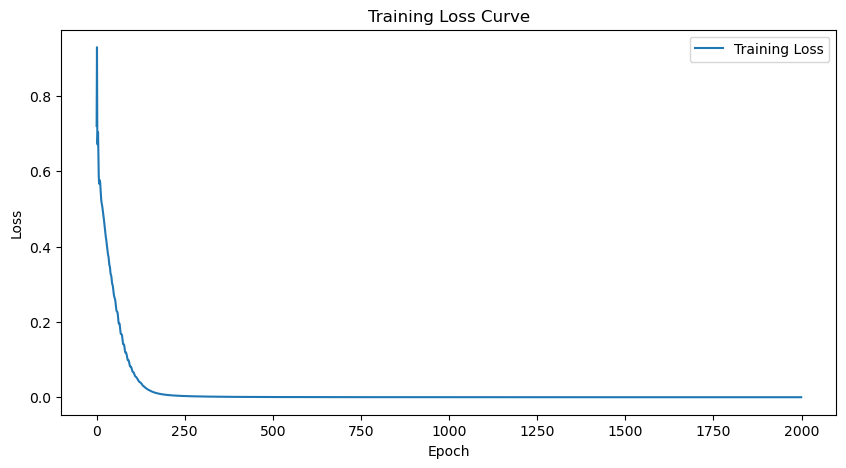

Final Model Accuracy: 82.96%


In [9]:
input_dim = X_train.shape[1]
hidden_dim = 256 
print(f"Training MLP model with input_dim={input_dim} and hidden_dim={hidden_dim}")

custom_mlp, losses, best_accuracy = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [10]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_token_TSNE2.pth'.


In [11]:
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

/tmp/ipykernel_1475759/2137335780.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()


                  precision    recall  f1-score   support

    infringement       0.93      0.70      0.80       283
non_infringement       0.77      0.95      0.85       298

        accuracy                           0.83       581
       macro avg       0.85      0.83      0.83       581
    weighted avg       0.85      0.83      0.83       581



: 